### in this task we are given an assignment to classify text by 20 possible classes.
our approach would be: 
    1. load the text. 
    2. clean it from stop words and non english words.
    3. split the big text files into smaller 10k sizs texts that will serve as examples.
    4. tokenize the texts using the top 20k frequent words.
    5. use only 2k of the words in each exampl.
    6. load a pretrained glove model weights that has a weight vector for each word.
    7. train a 1D convolutional neural network, ending in a softmax output over our 20 categories.
    8. evaluate with a classification matrix.

### importing libraries

In [1]:
import os
import sys
import numpy as np
import nltk
nltk.download("stopwords")
import tensorflow as tf
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\davidog16\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import re
import pandas as pd

In [3]:
import os
import sys
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant

### read textual data. the data is saves as 20 text files, where each file contains all the text on a given topic

In [38]:
TEXT_DATA_DIR='C:/Users/davidog16/Desktop/assigns/texts'



files = os.listdir(r'C:\Users\davidog16\Desktop\assigns\texts')
texts = []
labels_index = {}

for i,file in enumerate(files):

    path = '{}{}'.format(TEXT_DATA_DIR,'/{}'.format(file))

    text  = open(path, 'r').read()

    texts.append(text)
    
    labels_index[file[0:-4]] = i
    
labels_id = np.arange(len(list(labels_index.keys())))

In [18]:
labels_names = list(labels_index.keys())

### remove label, stop words, len(word)==1 from text, leaveing only english.


In [81]:
stops = list(set(stopwords.words("english"))) + ['newsgroup','id','document']
for i in range(len(texts)):
    texts[i] = texts[i].replace('{}'.format(labels_names[i]), ' ')
    texts[i] = re.sub(r'[^A-Za-z]', ' ', texts[i])
    split = texts[i].split()
    split = [word for word in split if word.lower() not in stops] 
    split = [word for word in split if len(word)>1] 

    texts[i] = " ".join(split)

### load weights of pretrained glove model. the loaded weights contain a eature vector for every word. the vecors represent a space in which similar meaning words should be closer.

In [21]:
embeddings_index = {}
with open(r'C:\Users\davidog16\Desktop\assigns\glove\glove.6B.100d.txt',encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [127]:
labels_names = list(labels_index.keys())

### we are going to split the data into substrings with constant length. therefore if the texts length differ, so will the distribution of our following label vector.

### bar plot showing the different lengths of the original 20 data files

<BarContainer object of 20 artists>

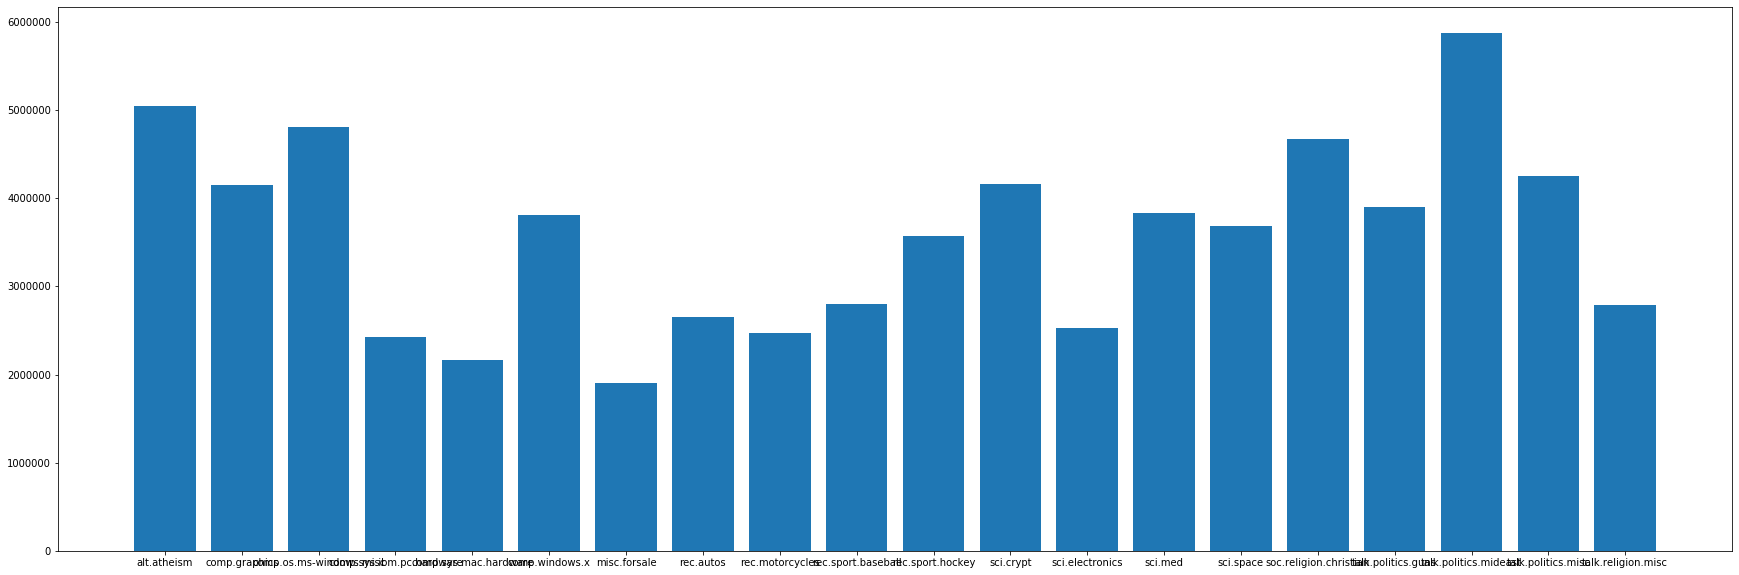

In [178]:
plt.figure(figsize=(30,10))
plt.bar(labels_names,[len(text) for text in texts])

### splitting the data as such that we obtain a corpu of texts of length 10k with their corresponding label.

In [126]:
#create two lists, one fore texts sizes of 10k (last one would be ~6k)
# and the other for thier labels

texts_splitted = []
ids = []
for i,label in enumerate(labels_names):
    
    x = texts[i]
    chunks, chunk_size = len(x), 10000
    for i in range(0, chunks, chunk_size):
    
        texts_splitted.append(x[i:i+chunk_size])
        ids.append(label)

### distribution of our label afer splitting (sanity check)

<BarContainer object of 20 artists>

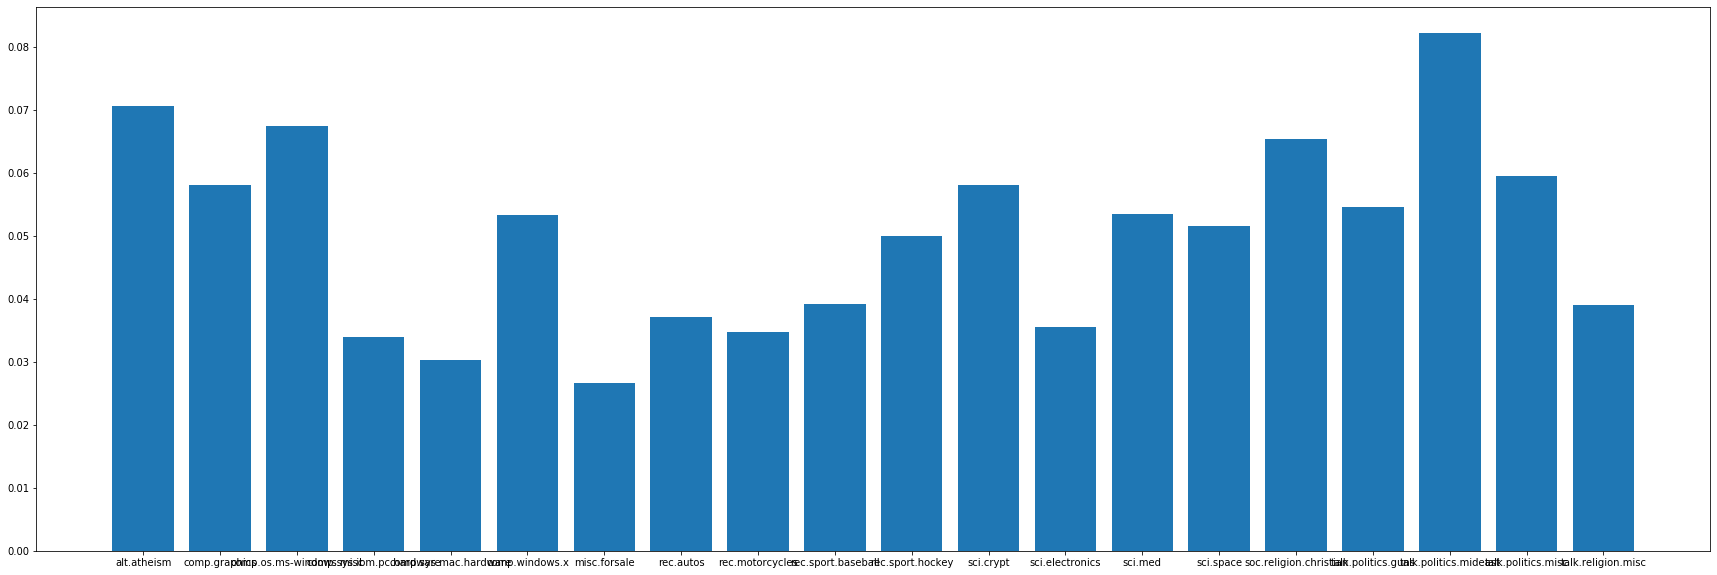

In [177]:
plt.figure(figsize=(30,10))
plt.bar(labels_names,[ids.count('{}'.format(name))/len(ids) for name in labels_names])


### looks like similar distribution to the length as expected

In [131]:
ids2 = [labels_index[i] for i in ids]

### setting variabels for the tokenizer and following model.

In [ ]:
MAX_SEQUENCE_LENGTH = 2000 # will be used in padding the texts
MAX_NUM_WORDS = 20000 # will be used for the tokenizer vocabulary size
EMBEDDING_DIM = 100 # dim of embedings
VALIDATION_SPLIT = 0.2 # size of test set

### setting a tokenizer and converting the raw texts to sequences ot integers.

In [120]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts_splitted)
sequences = tokenizer.texts_to_sequences(texts_splitted)

In [147]:
sequences[0][0:10]

[1621, 1621, 2948, 300, 109, 3, 1016, 785, 398, 1083]

### the correspoing tokenizer vocabulary and converting dict

In [155]:
word_index = tokenizer.word_index

### pad the sequences. for texts that are longer it takes the last

In [128]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) # currently takes the last 1000

In [132]:
labels = to_categorical(np.asarray(ids2))

In [133]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (4174, 2000)
Shape of label tensor: (4174, 20)


In [134]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size=0.33, random_state=42,stratify=labels)

### check stratified

In [135]:
test_label_list = [y_val[i].argmax() for i in range(y_val.shape[0])]
train_label_list = [y_train[i].argmax() for i in range(y_train.shape[0])]

In [136]:
pd.Series(test_label_list).value_counts(normalize=True).sort_values()

6     0.026125
4     0.030479
3     0.033382
8     0.034107
12    0.035559
7     0.036284
9     0.037736
19    0.039187
10    0.046444
5     0.052975
14    0.055152
16    0.055152
13    0.056604
2     0.057329
18    0.059507
11    0.060958
1     0.060958
15    0.065312
0     0.071118
17    0.085631
dtype: float64

In [52]:
pd.Series(train_label_list).value_counts(normalize=True).sort_values()

6     0.026387
4     0.030447
3     0.033491
8     0.034168
12    0.036198
7     0.037212
9     0.038566
19    0.039242
10    0.046346
5     0.052436
14    0.054465
16    0.055142
13    0.056157
2     0.056495
18    0.059878
1     0.060555
11    0.061231
15    0.065629
0     0.071042
17    0.084912
dtype: float64

### looks like our split is stratified by the label


In [141]:
### prepare embedding matrix

In [137]:
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
        # the vectors  for the first 1000 mot occoured words

### keras embedding layer

In [138]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [139]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)


x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)


preds = Dense(len(labels_index), activation='softmax')(x)

In [140]:
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=9, batch_size=128,callbacks=[early_stopping])

Train on 2796 samples, validate on 1378 samples
Epoch 1/9
2796/2796 [==============================] - 53s 19ms/sample - loss: 2.8249 - acc: 0.1284 - val_loss: 2.4433 - val_acc: 0.1814
Epoch 2/9
2796/2796 [==============================] - 51s 18ms/sample - loss: 1.9681 - acc: 0.3408 - val_loss: 1.5038 - val_acc: 0.4710
Epoch 3/9
2796/2796 [==============================] - 52s 19ms/sample - loss: 1.3942 - acc: 0.5054 - val_loss: 1.3462 - val_acc: 0.5138
Epoch 4/9
2796/2796 [==============================] - 54s 19ms/sample - loss: 1.1139 - acc: 0.5987 - val_loss: 0.9646 - val_acc: 0.6321
Epoch 5/9
2796/2796 [==============================] - 59s 21ms/sample - loss: 0.8291 - acc: 0.6978 - val_loss: 0.9315 - val_acc: 0.6778
Epoch 6/9
2796/2796 [==============================] - 55s 20ms/sample - loss: 0.6949 - acc: 0.7450 - val_loss: 1.0582 - val_acc: 0.6125
Epoch 7/9
2796/2796 [==============================] - 53s 19ms/sample - loss: 0.5987 - acc: 0.7958 - val_loss: 0.5087 - val_acc: 

### during training we can see that our val acc is higher then the training acc, while we would expect it to be the other way aruound. this should send use checkign the way we plitted the data, or evaluate our model using cross validation.

In [142]:
prediction = model.predict(x_val)

In [143]:
final_preds = [prediction[i].argmax() for i in range(prediction.shape[0])]
val_label_array = [y_val[i].argmax() for i in range(y_val.shape[0])]

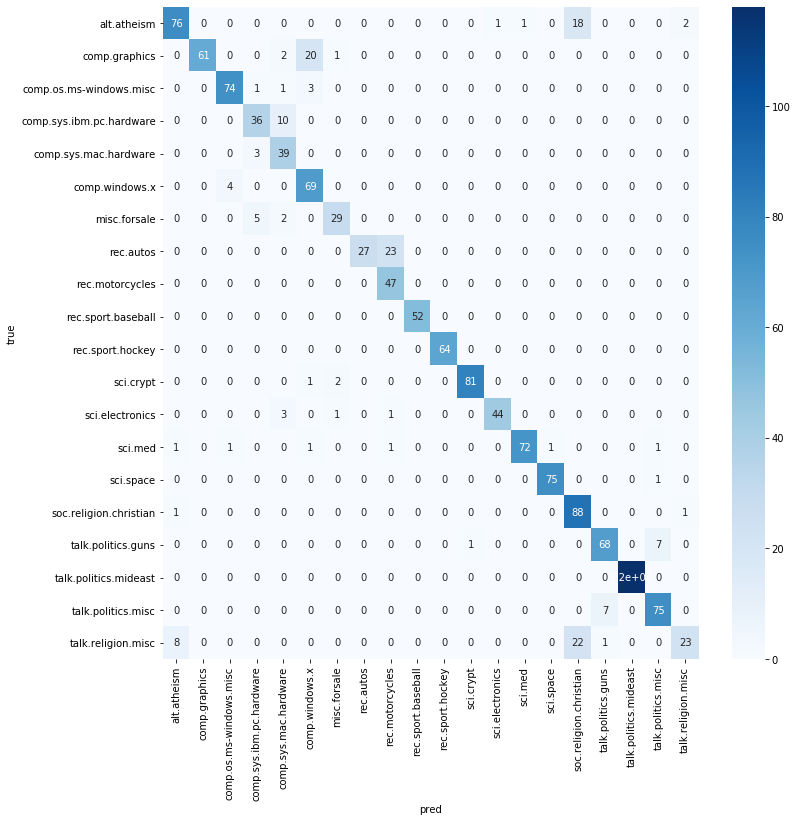

In [144]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cnf_matrix = confusion_matrix(val_label_array, final_preds)

plt.figure(figsize=(12,12))
df_cm = pd.DataFrame(cnf_matrix, index = labels_names,
                  columns = labels_names)
sns.heatmap(df_cm, annot=True,cmap="Blues")
plt.ylabel('true')
plt.xlabel('pred')
plt.show()

### our total accuracy is 88% on the test set.
### there are couples of similar topics that make the model miss such as tals.religion.misc and talk.religion.christian

In [145]:
from sklearn.metrics import classification_report
print(classification_report(val_label_array, final_preds))


              precision    recall  f1-score   support

           0       0.88      0.78      0.83        98
           1       1.00      0.73      0.84        84
           2       0.94      0.94      0.94        79
           3       0.80      0.78      0.79        46
           4       0.68      0.93      0.79        42
           5       0.73      0.95      0.83        73
           6       0.88      0.81      0.84        36
           7       1.00      0.54      0.70        50
           8       0.65      1.00      0.79        47
           9       1.00      1.00      1.00        52
          10       1.00      1.00      1.00        64
          11       0.99      0.96      0.98        84
          12       0.98      0.90      0.94        49
          13       0.99      0.92      0.95        78
          14       0.99      0.99      0.99        76
          15       0.69      0.98      0.81        90
          16       0.89      0.89      0.89        76
          17       1.00    

### thank you for the opportunity it was fun
### what I would have done more
1. investigate the data the text itself, check those correlated classes, measure the correlation by word occourences with chi or pearson
2. cross validation, hyper parameter tunning
3. get fature importane foor each class
4. plot a summary of shap values for each class in an attmept to explain the model.
5. load and use bert language model weights for deeper semantic meaning
6. test a solution without DL